In [1]:
import math
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, Aer, transpile, assemble
import pandas as pd
from fractions import Fraction
from numpy.random import randint

In [2]:
N=35
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1048)
#my_shor = Shor(quantum_instance=quantum_instance)#algoritimo de Shor que já vem implementado, descomente para rodar
#result = my_shor.factor(N)
#print(f"The list of factors of {N} as computed by the Shor's algorithm is {result.factors[0]}.")

In [3]:
def c_amodN(a, power):
    """Controlled multiplication by a mod N"""
    #if a not in [2,4,5,8,11,13]:
     #   raise ValueError("'a' must be 2,4,5,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        #if a in [2,13]:
            #U.swap(0,1)
            #U.swap(1,2)
            #U.swap(2,3)
        #if a in [5,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        #if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        #if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"%i^%i mod {N}" % (a, power)
    c_U = U.control()
    return c_U

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [20]:
# Specify variables
n_count = 8  # number of counting qubits
#np.random.seed(52) # This is to make sure we get reproduceable results
a = randint(2, N)
print(a)

11


In [21]:
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amodN(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                                     ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                             │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │               │                                                                                                             │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │               │               │                                                                                             │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │               │               │               │                                                                             │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────■────────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │               │               │               │                │                                                            │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────■───────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │               │               │               │                │                │                                           │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────■──────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │               │               │               │                │                │                │                          │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────┼────────────────■─────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴────────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├┤0              ├┤0              ├┤0              ├┤0               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │              ││              ││              ││              ││               ││               ││               ││                │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├┤1              ├┤1              ├┤1              ├┤1               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  11^1 mod 35 ││  11^2 mod 35 ││  11^4 mod 35 ││  11^8 mod 35 ││  11^16 mod 35 ││  11^32 mod 35 ││  11^64 mod 35 ││  11^128 mod 35 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├┤2              ├┤2              ├┤2              ├┤2               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│              ││              ││              ││              ││              

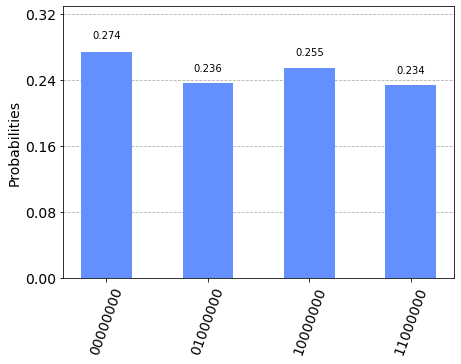

In [22]:
from qiskit import execute
aer_sim = Aer.get_backend('aer_simulator')
#t_qc = transpile(qc, aer_sim)
#qobj = assemble(t_qc)
results = execute(qc,aer_sim).result()
counts = results.get_counts()
plot_histogram(counts)

In [23]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  01000000(bin) =  64(dec)   64/256 = 0.25


In [24]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [25]:
# Get fraction that most closely resembles 0.666
# with denominator < N
Fraction(0.666).limit_denominator(N)

Fraction(2, 3)

In [26]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.00      0/1            1
2   0.75      3/4            4
3   0.25      1/4            4


In [27]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod {N}) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [56]:
a2jmodN(a, 2049, 53)

28

In [57]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [58]:
def qpe_amodN(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amodN(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    #t_qc = transpile(qc, aer_sim)
    #qobj = assemble(t_qc, shots=1)
    result = execute(qc, aer_sim, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [59]:
phase = qpe_amodN(a) # Phase = s/r
Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r

Register Reading: 10000000
Corresponding Phase: 0.500000


Fraction(1, 2)

In [60]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

2


In [61]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[5, 1]


In [62]:
#a = 13
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amodN(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , N)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 5 and 1
*** Non-trivial factor found: 5 ***
